# Project Set Up

In [1]:
import sys
import os
current_dir = os.getcwd()
from pathlib import Path
sys.path.append(str(Path(current_dir).parent))

In [2]:
from tools.data_loader import read_data
import json
import pandas as pd
import matplotlib.pyplot as plt

/data/long/miniconda3/envs/delegate/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# List of result folders
folders = [
    "results_Gemini-2.5-Flash_500samples_math_500_path",
    "results_Gemini-2.5-Flash-Lite_500samples_math_500_path",
    "results_Gemini-2.5-Pro_500samples_math_500_path",
    "results_Qwen2.5-Math-1.5B-Instruct_500samples_math_500path",
    "results_Qwen2.5-Math-7B-Instruct_500samples_math_500path",
    "results_Gemini-2.5-Flash_Qwen-1.5_500samples_math_500_path"
]

=== Accuracy by Subject ===
                        correct  total  accuracy
subject                                         
Algebra                     113    124  0.911290
Intermediate Algebra         88     97  0.907216
Number Theory                55     62  0.887097
Precalculus                  46     56  0.821429
Counting & Probability       31     38  0.815789
Prealgebra                   66     82  0.804878
Geometry                     27     41  0.658537

=== Accuracy by Hand-off Model ===
                  correct  total  accuracy
hand_off_model                            
LLM Math Experts      217    248  0.875000
SLM Math Expert       209    252  0.829365


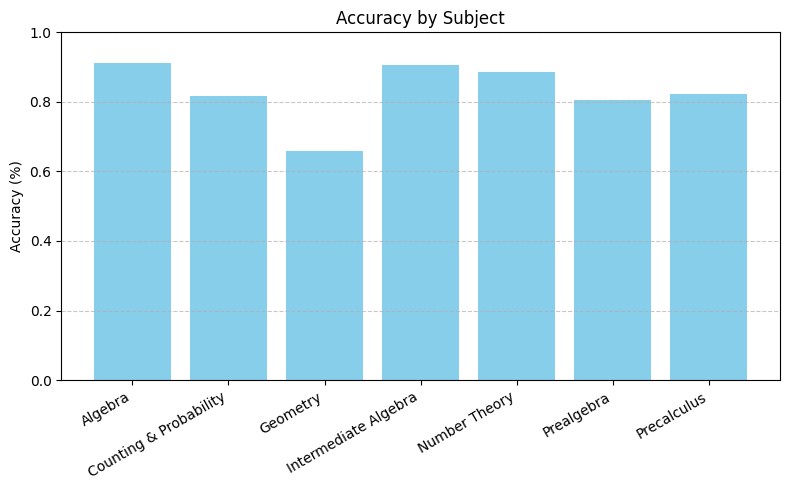

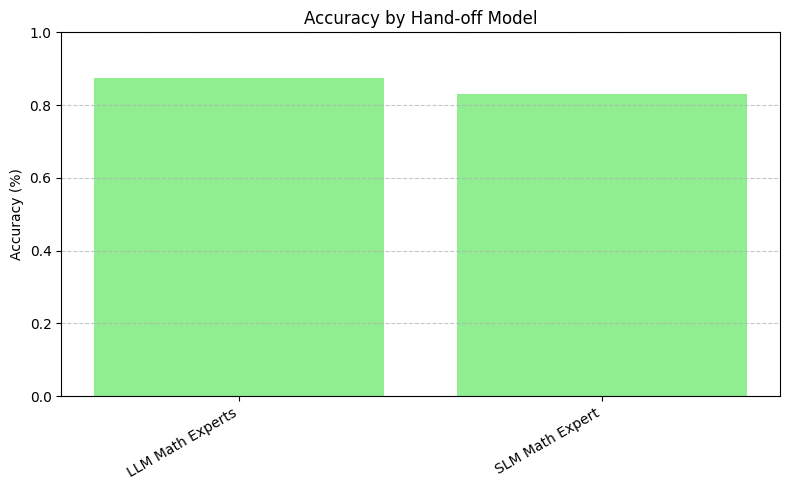

In [4]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Load data ----------
results_dir = f"{folders[-1]}/results_router.json"
with open(results_dir, "r") as f:
    data = json.load(f)

results = pd.DataFrame(data["results"])

# ---------- Compute per-subject correctness ----------
subject_stats = (
    results.groupby("subject")["is_correct"]
    .agg(["sum", "count"])
    .rename(columns={"sum": "correct", "count": "total"})
)
subject_stats["accuracy"] = subject_stats["correct"] / subject_stats["total"]

# ---------- Compute per-model correctness ----------
model_stats = (
    results.groupby("hand_off_model")["is_correct"]
    .agg(["sum", "count"])
    .rename(columns={"sum": "correct", "count": "total"})
)
model_stats["accuracy"] = model_stats["correct"] / model_stats["total"]

# ---------- Print reports ----------
print("=== Accuracy by Subject ===")
print(subject_stats.sort_values("accuracy", ascending=False))
print("\n=== Accuracy by Hand-off Model ===")
print(model_stats.sort_values("accuracy", ascending=False))

# ---------- Plot histogram: Accuracy by Subject ----------
plt.figure(figsize=(8, 5))
plt.bar(subject_stats.index, subject_stats["accuracy"], color="skyblue")
plt.title("Accuracy by Subject")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=30, ha="right")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# ---------- Plot histogram: Accuracy by Hand-off Model ----------
plt.figure(figsize=(8, 5))
plt.bar(model_stats.index, model_stats["accuracy"], color="lightgreen")
plt.title("Accuracy by Hand-off Model")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=30, ha="right")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
